In [111]:
import pandas as pd
from umap import UMAP
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy  as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

sns.set_theme(style="ticks")
random_state = 42

Load data

In [112]:
wine = pd.read_csv("winequality-red.csv")

wine_X = wine.loc[:,"fixed acidity":"alcohol"]
wine_y = wine.quality

X_train, X_test, y_train, y_test = train_test_split(wine_X, wine_y)

In [387]:
scaler = RobustScaler()

regressor = KNeighborsRegressor(
    weights="distance",
    metric="correlation",
    n_neighbors=40
)

pipeline = make_pipeline(
    scaler, regressor
)

pipeline.fit(X=X_train, y=y_train)
pred = pipeline.predict(X=X_test)
print("Score: {:.2}".format(pipeline.score(X_test, y_test)))
print("MSE: {:.2}".format(mean_squared_error(y_test, pred)))

Score: 0.5
MSE: 0.3


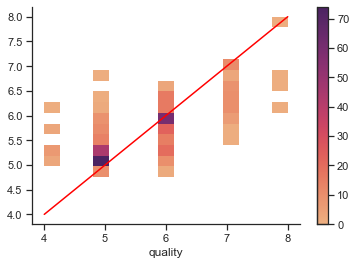

In [388]:
sns.histplot(x=y_test, y=pred, cbar=True, cmap="flare")
sns.lineplot(x=np.arange(4,9), y=np.arange(4, 9), color="red")
sns.despine()

<AxesSubplot:xlabel='quality'>

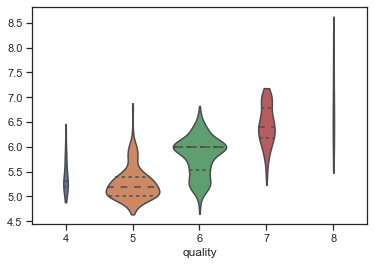

In [398]:
sns.violinplot(
    x=y_test, 
    y=pred, 
    cbar=True, 
    palette="deep", 
    cut=1,
    inner="quartile",
    scale="count"
    )
# sns.lineplot(x=np.arange(4,9), y=np.arange(4, 9), color="red")


In [393]:
mapper = UMAP(
    n_components=2,
    # densmap=True,
    metric="correlation",
    # output_metric="correlation",
    target_metric="l2",
    n_neighbors=100,
    target_weight=0.3,
    min_dist=0
)

embedding = mapper.fit_transform(
    X=scaler.fit_transform(wine_X),
    y=wine_y
)

<AxesSubplot:>

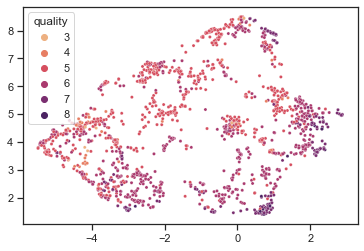

In [394]:
sns.scatterplot(
    x=embedding[:,0],
    y=embedding[:,1],
    hue=wine_y,
    s=10,
    palette="flare"
)